In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
import loompy

In [11]:
#sys.path

['',
 '/home/ubuntu/miniconda3/envs/velocyto/lib/python36.zip',
 '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6',
 '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/lib-dynload',
 '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages',
 '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/loompy-2.0.14-py3.6.egg',
 '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [3]:
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

In [4]:
#some basic config...
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

2018-12-13 01:09:29,163 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [5]:
# plotting utility functions

def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

In [6]:
import os

In [7]:
cwd = os.getcwd()
print (cwd)

/home/ubuntu/velocyto/Dyrk


In [8]:
#dir_list=next(os.walk('./'))[1]

In [9]:
#print(dir_list)

['control', '.ipynb_checkpoints', 'KO', 'het']


In [18]:
#os.chdir("/home/ubuntu/velocyto")

In [10]:
#read individual loom file. each file comes from 1 channel of 10X 
Dyrk_control = loompy.connect("./control/brain_control/velocyto/brain_control.loom")

In [11]:
Dyrk_het = loompy.connect("./het/brain_het/velocyto/brain_het.loom")

In [12]:
Dyrk_KO = loompy.connect("./KO/brain_knockout/velocyto/brain_knockout.loom")

In [13]:
#take a look at the individual loom files
Dyrk_KO

,,,,,,CellID,brain_knockout:AAATGCCGTCATGCCGx,brain_knockout:AACGTTGCACTGTTAGx,brain_knockout:AACTCAGGTAGAAGGAx,brain_knockout:AACCGCGAGCGCTTATx,brain_knockout:AAAGATGGTCCTCTTGx,brain_knockout:AAAGATGAGATGCGACx,brain_knockout:AACCGCGTCTCAACTTx,brain_knockout:AACCGCGCAGGCAGTAx,brain_knockout:AAATGCCCAACAACCTx,brain_knockout:AACACGTTCTACCAGAx,...
Accession,Chromosome,End,Gene,Start,Strand,,,,,,,,,,,,...
ENSMUSG00000051951,1,3671498,Xkr4,3205901,-,,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...
ENSMUSG00000103377,1,3368549,Gm37180,3365731,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000104017,1,3377788,Gm37363,3375556,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103025,1,3467285,Gm37686,3464977,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103201,1,3514507,Gm37329,3512451,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103161,1,3595903,Gm38148,3592892,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000102331,1,3658904,Gm19938,3647309,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000088333,1,3783933,Gm27396,3783876,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000102343,1,3986215,Gm37381,3905739,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


In [14]:
#access the layer named "unspliced"
Dyrk_KO["unspliced"][:,:]

array([[0, 1, 2, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [15]:
#surely there is another layer named "spliced"
Dyrk_KO["spliced"][:,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [16]:
#The main layer. looks like spliced+unspliced.
Dyrk_KO[""][:,:]

array([[0., 1., 2., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
#I wonder whether channel name is incorporated in the CellID
Dyrk_KO_CellID=Dyrk_KO.ca["CellID"]

In [18]:
print(Dyrk_KO_CellID)
#so it looks like the loom has included channel name as part of the cell name. good!

['brain_knockout:AAATGCCGTCATGCCGx' 'brain_knockout:AACGTTGCACTGTTAGx'
 'brain_knockout:AACTCAGGTAGAAGGAx' ... 'brain_knockout:TTTGCGCCAATGAATGx'
 'brain_knockout:TTGTAGGAGAACTCGGx' 'brain_knockout:TTTACTGTCGGAATCTx']


In [21]:
#import glob

In [48]:
#loomList=glob.glob("bw_data/*.loom")

In [19]:
#These are 3 loom files I want to combine
loomList=["./control/brain_control/velocyto/brain_control.loom","./het/brain_het/velocyto/brain_het.loom","./KO/brain_knockout/velocyto/brain_knockout.loom"]

In [20]:
print(loomList)

['./control/brain_control/velocyto/brain_control.loom', './het/brain_het/velocyto/brain_het.loom', './KO/brain_knockout/velocyto/brain_knockout.loom']


In [21]:
#Now I can combine those 3 loom files to generate the DyrkCombined.loom
loompy.combine(loomList, "./DyrkCombined.loom", key="Accession")

2018-12-13 01:22:02,738 - WARNING - ╭── 'batch_scan_layers' is deprecated. Use 'scan' instead
2018-12-13 01:22:02,739 - WARNING - ╰──> at /home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/loompy/loompy.py, line 471
2018-12-13 01:22:20,769 - WARNING - ╭── 'batch_scan_layers' is deprecated. Use 'scan' instead
2018-12-13 01:22:20,772 - WARNING - ╰──> at /home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/loompy/loompy.py, line 471


In [22]:
#connect to the final combined loom file
DyrkLoom = loompy.connect("./DyrkCombined.loom")

In [23]:
#take a look at this file
DyrkLoom

,,,,,,CellID,brain_control:AAACGGGCAGCTGTGCx,brain_control:AAACGGGCACCTGGTGx,brain_control:AACGTTGCAAAGAATCx,brain_control:AAACGGGAGATGCCTTx,brain_control:AACACGTAGACTTTCGx,brain_control:AAAGCAAGTAGGACACx,brain_control:AAAGCAAGTATCACCAx,brain_control:AACGTTGAGTGGGATCx,brain_control:AAATGCCCACATGGGAx,brain_control:AAACGGGCACCATGTAx,...
Accession,Chromosome,End,Gene,Start,Strand,,,,,,,,,,,,...
ENSMUSG00000051951,1,3671498,Xkr4,3205901,-,,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103377,1,3368549,Gm37180,3365731,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000104017,1,3377788,Gm37363,3375556,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103025,1,3467285,Gm37686,3464977,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103201,1,3514507,Gm37329,3512451,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103161,1,3595903,Gm38148,3592892,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000102331,1,3658904,Gm19938,3647309,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000088333,1,3783933,Gm27396,3783876,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000102343,1,3986215,Gm37381,3905739,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


In [24]:
DyrkLoom["spliced"][:,:]

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [25]:
DyrkLoom["unspliced"][:,:]

array([[0, 4, 1, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [26]:
DyrkLoom[""][:,:]

array([[0., 4., 2., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
DyrkCellID=DyrkLoom.ca["CellID"]

In [28]:
print(DyrkCellID)

['brain_control:AAACGGGCAGCTGTGCx' 'brain_control:AAACGGGCACCTGGTGx'
 'brain_control:AACGTTGCAAAGAATCx' ... 'brain_knockout:TTTGCGCCAATGAATGx'
 'brain_knockout:TTGTAGGAGAACTCGGx' 'brain_knockout:TTTACTGTCGGAATCTx']


In [29]:
type(DyrkCellID)

numpy.ndarray

In [30]:
len(DyrkCellID)

9542

In [31]:
#write CellID into a file. Then I can pull analysis results and metadata from elsewhere based on the cell names provided by this csv file.
DyrkCellID.tofile('./DyrkCellID.csv',sep=',',format='%s')

In [ ]:
#Using the list of CellID, I get each cell's embedding, TSNE in this case, and its cluster ID from Seurat 

In [ ]:
#To read TSNE coordinates and cluster ID files:

In [32]:
import pandas as pd

In [33]:
Dyrk_TSNE1 = pd.read_csv("./dyrk1a.1k.gene_TSNE1_Loomorder.csv",header=None)




In [34]:
print(Dyrk_TSNE1)

              0
0      4.425140
1     -1.789705
2     -2.934482
3     24.451610
4    -18.736410
5           NaN
6      6.644354
7    -15.709280
8    -36.123530
9    -18.291270
10    -5.698129
11   -35.915070
12   -33.344530
13   -16.410370
14          NaN
15   -31.667350
16   -33.521020
17    15.606500
18    32.558060
19     5.948492
20   -17.255730
21    -1.491880
22   -40.355280
23    -7.440836
24   -20.546910
25    27.600850
26    17.483950
27    17.995620
28          NaN
29   -18.960770
...         ...
9512  10.860610
9513   6.561575
9514        NaN
9515  18.733840
9516   4.495822
9517 -34.728880
9518        NaN
9519 -14.835200
9520   2.078573
9521  -1.311516
9522  25.190810
9523  -2.093380
9524  27.448750
9525 -23.113790
9526  22.883300
9527  31.940000
9528  12.884570
9529  15.557800
9530  12.877350
9531   4.875719
9532  11.250660
9533  19.089910
9534  -0.247640
9535   2.686386
9536   0.780465
9537  15.234760
9538  23.134450
9539  10.402090
9540  22.857400
9541 -30.110730

[9542 r

In [35]:
type(Dyrk_TSNE1)

pandas.core.frame.DataFrame

In [36]:
len(Dyrk_TSNE1)

9542

In [37]:
conv_TSNE1=Dyrk_TSNE1.values.flat

In [38]:
type(conv_TSNE1)

numpy.flatiter

In [39]:
DyrkLoom.ca.TSNE1=np.asarray(conv_TSNE1)

In [40]:
Dyrk_TSNE2 = pd.read_csv("./dyrk1a.1k.gene_TSNE2_Loomorder.csv",header=None)


In [41]:
conv_TSNE2=Dyrk_TSNE2.values.flat

In [42]:
DyrkLoom.ca.TSNE2=np.asarray(conv_TSNE2)

In [43]:
Dyrk_cluster_res08 = pd.read_csv("./dyrk1a.1k.gene_res08_Loomorder.csv",header=None)
conv_res08=Dyrk_cluster_res08.values.flat
str_res08=["%.1f" % x for x in conv_res08]
type(str_res08)

list

In [51]:
DyrkLoom.ca.cluster08=np.asarray(str_res08)

In [52]:
DyrkLoom


,,,,,,CellID,brain_control:AAACGGGCAGCTGTGCx,brain_control:AAACGGGCACCTGGTGx,brain_control:AACGTTGCAAAGAATCx,brain_control:AAACGGGAGATGCCTTx,brain_control:AACACGTAGACTTTCGx,brain_control:AAAGCAAGTAGGACACx,brain_control:AAAGCAAGTATCACCAx,brain_control:AACGTTGAGTGGGATCx,brain_control:AAATGCCCACATGGGAx,brain_control:AAACGGGCACCATGTAx,...
,,,,,,TSNE1,4.42514,-1.7897049999999999,-2.934482,24.451610000000002,-18.73641,nan,6.644353999999999,-15.70928,-36.12353,-18.29127,...
,,,,,,TSNE2,15.70307,33.283590000000004,32.065,10.9073,6.750564999999999,nan,-35.687090000000005,3.452369,4.069558,-0.06084799,...
,,,,,,cluster12,5.0,0.0,0.0,1.0,2.0,nan,4.0,2.0,3.0,2.0,...
,,,,,,cluster08,5.0,0.0,0.0,1.0,2.0,nan,4.0,2.0,3.0,2.0,...
Accession,Chromosome,End,Gene,Start,Strand,,,,,,,,,,,,...
ENSMUSG00000051951,1,3671498,Xkr4,3205901,-,,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103377,1,3368549,Gm37180,3365731,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000104017,1,3377788,Gm37363,3375556,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103025,1,3467285,Gm37686,3464977,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSMUSG00000103201,1,3514507,Gm37329,3512451,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


In [53]:
# Crate an analysis object
vlm = vcy.VelocytoLoom("./DyrkCombined.loom")

In [58]:
# Read column attributes form the loom file and specify colors
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])


In [59]:
type(vlm.ts)

numpy.ndarray

In [60]:
vlm.ts

array([[  4.42514 ,  15.70307 ],
       [ -1.789705,  33.28359 ],
       [ -2.934482,  32.065   ],
       ...,
       [ 10.40209 ,  23.36658 ],
       [ 22.8574  ,  -1.030908],
       [-30.11073 ,  -3.23845 ]])

In [55]:
colors_dict = {'1.0': np.array([ 0.95,  0.6,  0.1]), '2.0': np.array([ 0.85,  0.3,  0.1]), '3.0': np.array([ 0.8,  0.02,  0.1]),
             '4.0': np.array([ 0.81,  0.43,  0.72352941]), '5.0': np.array([ 0.61,  0.13,  0.72352941]), '6.0': np.array([ 0.9,  0.8 ,  0.3]),
             '7.0': np.array([ 0.7,  0.82 ,  0.6]), '8.0': np.array([ 0.448,  0.85490196,  0.95098039]),  '0.0': np.array([ 0.35,  0.4,  0.82]),
             '10.0': np.array([ 0.23,  0.3,  0.7]), 'nan': np.array([ 0.05,  0.11,  0.51]), '12.0': np.array([ 0.2,  0.53,  0.71]),'15.0': np.array([ 0.3,  0.0,  0.5]),
              '9.0': np.array([ 0.1,  0.45,  0.3]), '11.0': np.array([ 0.3,  0.35,  0.5]),'13.0': np.array([ 0.3,  0.35,  0.9]),'14.0': np.array([ 0.0,  0.35,  0.5]),'16.0': np.array([ 0.3,  0.35,  0.0]),'17.0': np.array([ 0.3,  0.9,  0.5]),'18.0': np.array([ 0.9,  0.35,  0.5])}


In [56]:
vlm.set_clusters(vlm.ca["cluster08"], cluster_colors_dict=colors_dict)

TypeError: 'numpy.str_' object cannot be interpreted as an integer

2018-12-13 18:29:39,508 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


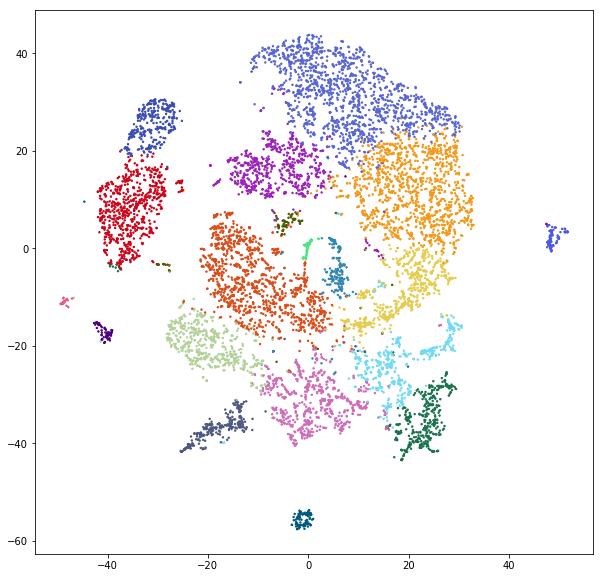

In [61]:
# Plot TSNE
plt.figure(figsize=(10,10))
vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=2)
for i in range(max(vlm.ca["cluster08"])):
    ts_m = np.median(vlm.ts[vlm.ca["cluster08"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(vlm.cluster_labels[vlm.ca["cluster08"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

In [64]:
#vlm.plot_fractions(chip_ix = np.unique(vlm.ca["cluster08"], return_inverse=1))


In [63]:
def plot_fractions_cluster(self, save2file: str=None) -> None:
        """Plots a barplot showing the abundance of spliced/unspliced molecules in the dataset

        Arguments
        ---------
        save2file: str (default: None)
            If not None specifies the file path to which plots get saved

        Returns
        -------
        Nothing, it plots a barplot
        """
        plt.figure(figsize=(3.2, 5))
        try:
            chips, chip_ix = np.unique(self.ca["cluster08"], return_inverse=1)
        except KeyError:
            chips, chip_ix = np.unique([i.split(":")[0] for i in self.ca["CellID"]], return_inverse=1)
        n = len(chips)
        for i in np.unique(chip_ix):
            tot_mol_cell_submatrixes = [X[:, chip_ix == i].sum(0) for X in [self.S, self.A, self.U]]
            total = np.sum(tot_mol_cell_submatrixes, 0)
            _mean = [np.mean(j / total) for j in tot_mol_cell_submatrixes]
            _std = [np.std(j / total) for j in tot_mol_cell_submatrixes]
            plt.ylabel("Fraction")
            plt.bar(np.linspace(-0.2, 0.2, n)[i] + np.arange(3), _mean, 0.5 / (n * 1.05), label=chips[i])
            plt.errorbar(np.linspace(-0.2, 0.2, n)[i] + np.arange(3), _mean, _std, c="k", fmt="none", lw=1, capsize=2)

            # Hide the right and top spines
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            # Only show ticks on the left and bottom spines
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')
            plt.gca().spines['left'].set_bounds(0, 0.8)
            plt.legend()
            
        plt.xticks(np.arange(3), ["spliced", "ambiguous", "unspliced"])
        plt.tight_layout()
        if save2file:
            plt.savefig(save2file, bbox_inches="tight")

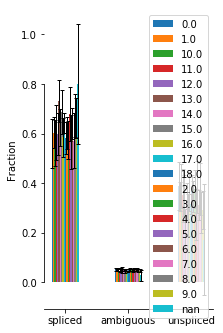

In [65]:
plot_fractions_cluster(vlm)

In [66]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.4))


In [67]:
vlm.filter_cells(bool_array=vlm.ca["cluster08"] != "nan")


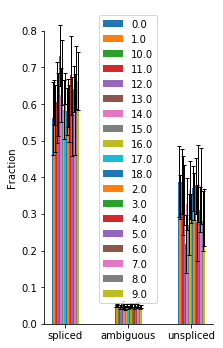

In [68]:
plot_fractions_cluster(vlm)

In [69]:
vlm.ts = np.column_stack([vlm.ca["TSNE1"], vlm.ca["TSNE2"]])


In [70]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

2018-12-13 18:33:13,440 - DEBUG - Filtering by detection level


2018-12-13 18:33:30,625 - DEBUG - svr_gamma set to 0.01099545521184577
2018-12-13 18:33:42,996 - DEBUG - Filtering by cv vs mean


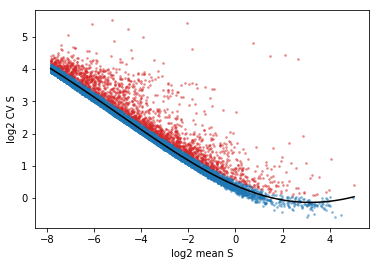

In [71]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [72]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

2018-12-13 18:34:02,794 - INFO - Cluster: b'0.0' (1502 cells)
2018-12-13 18:34:02,820 - INFO - Cluster: b'1.0' (1271 cells)
2018-12-13 18:34:02,844 - INFO - Cluster: b'10.0' (308 cells)
2018-12-13 18:34:02,855 - INFO - Cluster: b'11.0' (274 cells)
2018-12-13 18:34:02,865 - INFO - Cluster: b'12.0' (203 cells)
2018-12-13 18:34:02,872 - INFO - Cluster: b'13.0' (106 cells)
2018-12-13 18:34:02,875 - INFO - Cluster: b'14.0' (101 cells)
2018-12-13 18:34:02,879 - INFO - Cluster: b'15.0' (81 cells)
2018-12-13 18:34:02,882 - INFO - Cluster: b'16.0' (79 cells)
2018-12-13 18:34:02,886 - INFO - Cluster: b'17.0' (62 cells)
2018-12-13 18:34:02,888 - INFO - Cluster: b'18.0' (42 cells)
2018-12-13 18:34:02,891 - INFO - Cluster: b'2.0' (1154 cells)
2018-12-13 18:34:02,912 - INFO - Cluster: b'3.0' (690 cells)
2018-12-13 18:34:02,930 - INFO - Cluster: b'4.0' (682 cells)
2018-12-13 18:34:02,947 - INFO - Cluster: b'5.0' (637 cells)
2018-12-13 18:34:02,963 - INFO - Cluster: b'6.0' (602 cells)
2018-12-13 18:34

In [73]:
# best with sample and expression scaling
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))

46

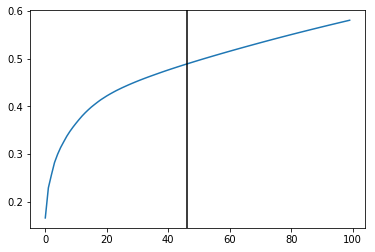

In [74]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [75]:
k = 50
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

2018-12-13 18:34:39,532 - DEBUG - First search the 400 nearest neighbours for 9199
2018-12-13 18:34:45,034 - DEBUG - Using the initialization network to find a 50-NN graph with maximum connectivity of 200
2018-12-13 18:34:45,087 - DEBUG - Returning sparse matrix


In [76]:
vlm.fit_gammas(limit_gamma=False, fit_offset=False)


In [77]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

2018-12-17 17:43:39,315 - DEBUG - Assigning font /b'F1' = '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-12-17 17:43:39,668 - DEBUG - Embedding font /home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-12-17 17:43:39,669 - DEBUG - Writing TrueType font.


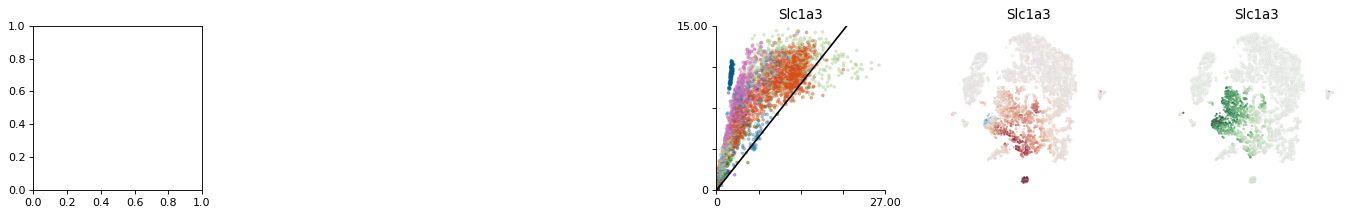

In [94]:
plt.figure(None, (17,2.8), dpi=80)
gs = plt.GridSpec(1,6)
for i, gn in enumerate(["Neurod1","Slc1a3"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
plt.savefig("./gene_selection.pdf")

2018-12-13 18:37:11,777 - DEBUG - Assigning font /b'F1' = '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-12-13 18:37:14,064 - DEBUG - Embedding font /home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-12-13 18:37:14,065 - DEBUG - Writing TrueType font.


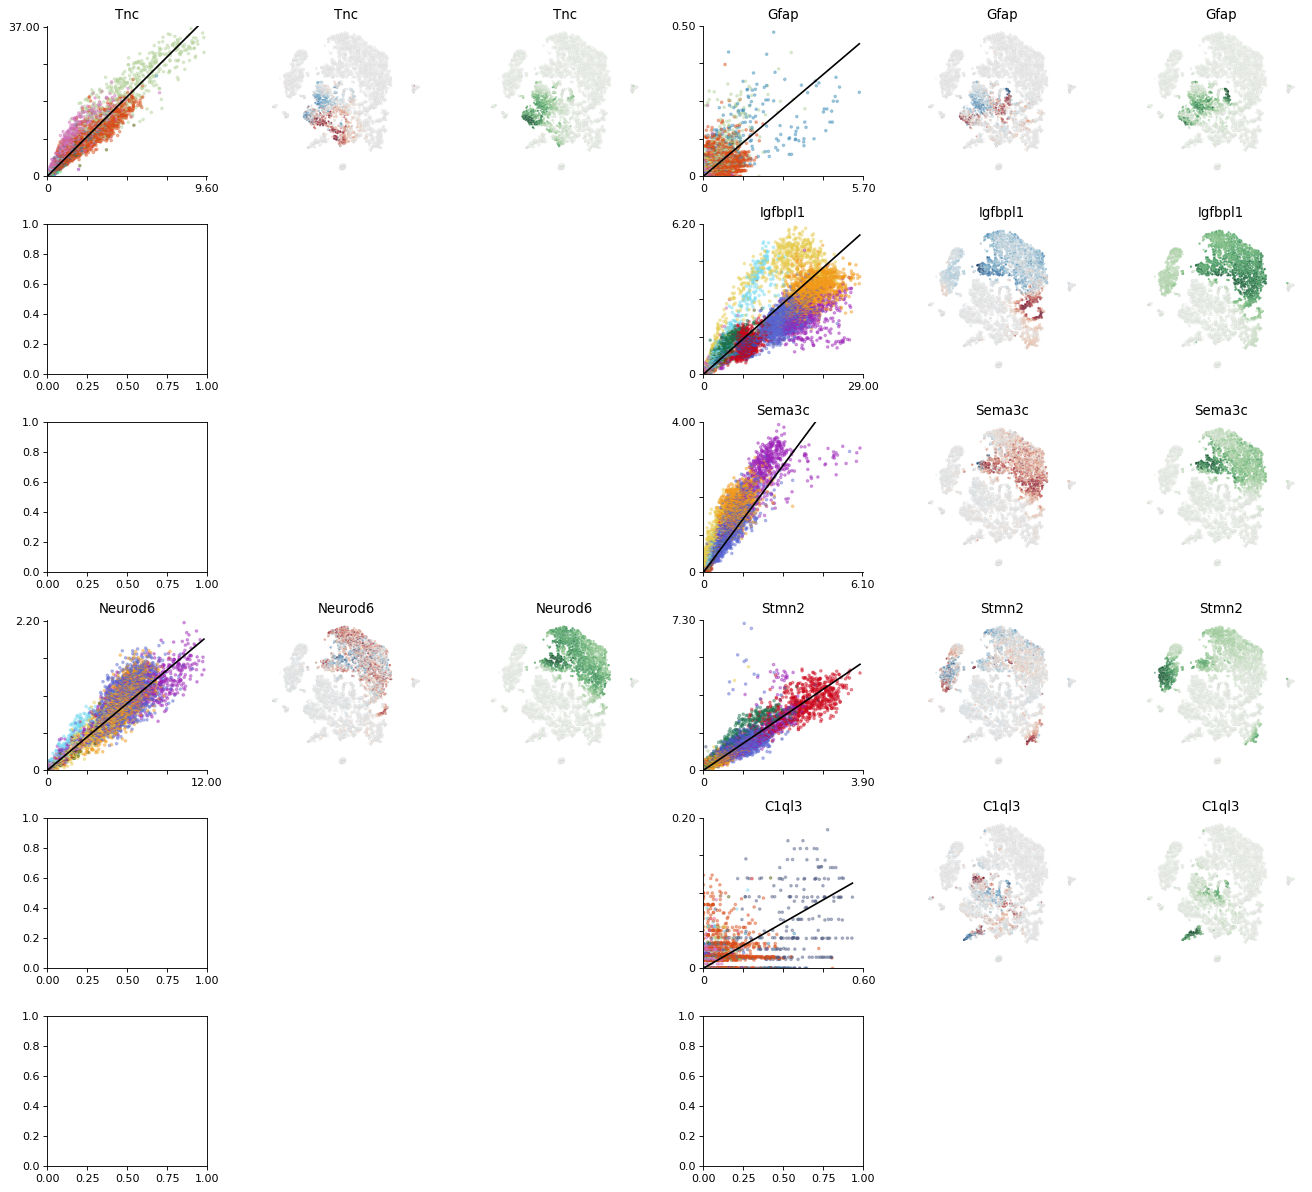

In [79]:
plt.figure(None, (16.5,15), dpi=80)
gs = plt.GridSpec(6,6)
for i, gn in enumerate(["Tnc", "Gfap", "Tac2","Igfbpl1", 'Ptprn',
                        "Sema3c", "Neurod6", "Stmn2", "Sema5a", "C1ql3", "Cpne4", "Cck"]):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    minimal_yticks(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    minimal_xticks(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    despline()
    
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)

    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
plt.savefig("./phase_selection.pdf")

In [80]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=50, knn_random=True, sampled_fraction=0.5)

2018-12-13 18:37:59,595 - DEBUG - Calculate KNN in the embedding space
2018-12-13 18:38:01,158 - DEBUG - Correlation Calculation 'knn_random'
2018-12-13 18:38:02,237 - DEBUG - Correlation Calculation for negative control
2018-12-13 18:38:03,450 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2018-12-13 18:38:03,678 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2018-12-13 18:38:03,679 - DEBUG - Done Correlation Calculation


In [87]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

2018-12-13 18:58:49,014 - DEBUG - Calculate transition probability
2018-12-13 18:58:50,697 - DEBUG - Calculate transition probability for negative control


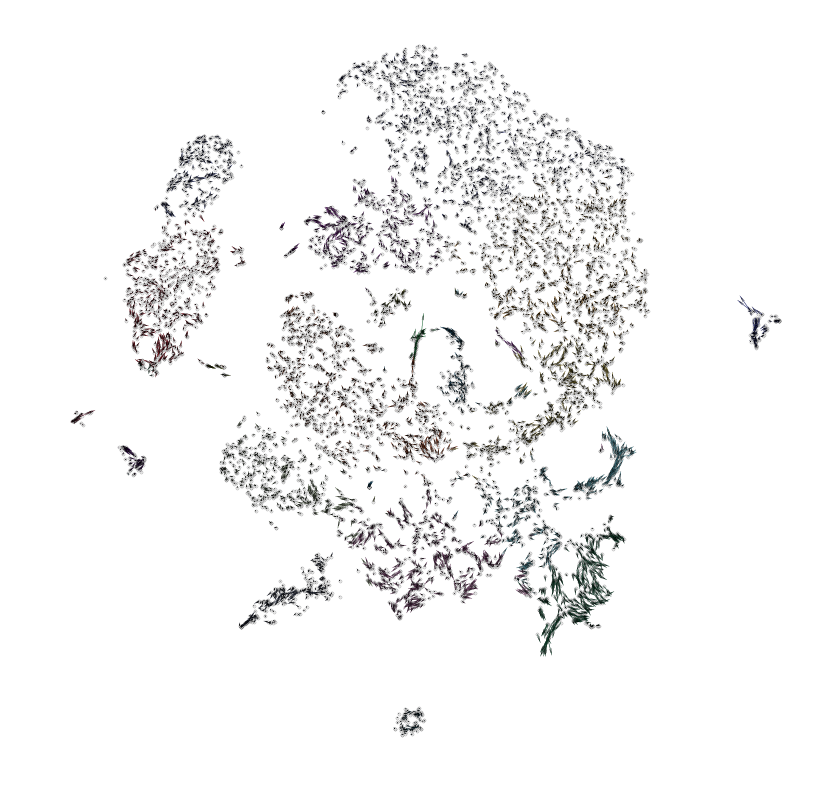

In [93]:
plt.figure(None,(14,14))
quiver_scale = 60

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=20, headwidth=5,linewidths=0.15, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("./Dyrk_full_arrows.pdf")

2018-12-13 18:59:21,222 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots
2018-12-13 18:59:21,514 - DEBUG - Assigning font /b'F1' = '/home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2018-12-13 18:59:21,684 - DEBUG - Embedding font /home/ubuntu/miniconda3/envs/velocyto/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2018-12-13 18:59:21,684 - DEBUG - Writing TrueType font.


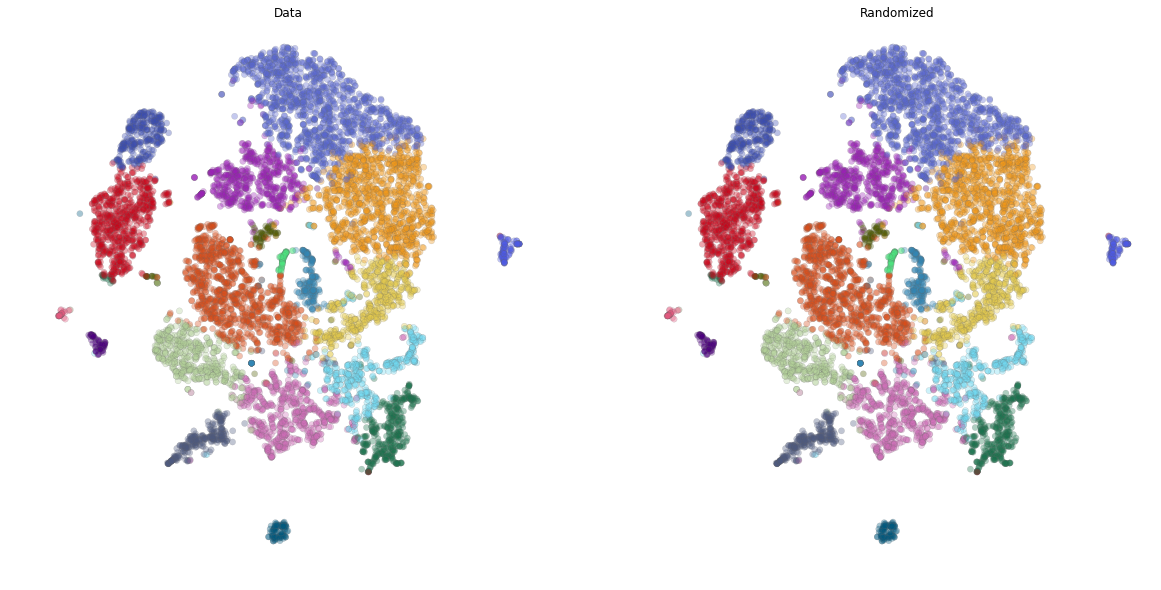

In [89]:
# initial divide by mean
plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale=0.48,
                     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=24, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=True, scale_type="absolute")
plt.savefig("./vectorfield.pdf")